## VAE

In [1]:
import os
import cv2
import glob
import random
import PIL
import numpy as np
import collections

import torch
import torchvision
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from utils import (
    Collector,
    VAELoss,
    trainer,
    plot_latent_tsne,
    generate_samples_between_centers,
    visualize_prediction,
)

from models import (
    deconv_resnet18,
    resnet18,
)

from sklearn.model_selection import train_test_split

%matplotlib inline

## Set Seeds

In [2]:
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Basic Params

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 50
bs = 812
num_workers = 0
mean = [0, 0, 0]
std = [1, 1, 1]
image_size = [128, 128, ]

## Data loader

In [4]:
class ImageFlickr30k(torch.utils.data.Dataset):
    
    ext = ['jpg', 'png', 'jpeg', ]
    
    def __init__(
        self,
        root: str,
        split: str,
        transform: A.core.composition.Compose,
    ) -> None:
        
        super().__init__()
        
        self.root = root
        self.transform = transform
        
        with open(os.path.join(root, f'{split}.txt'), 'r') as file:
            self.files_name = file.read().split('\n')
            
        self.files_name.pop()

    def __getitem__(
        self,
        idx: int,
    ) -> dict:
        
        img_path = os.path.join(self.root, 'flickr30k_images', self.files_name[idx])
        
        assert os.path.exists(img_path), f'Image path {img_path} does not exist!'
        file_ext = img_path.split('.')[1].lower()
        assert file_ext in self.ext, f'File ext {file_ext} is not in {self.ext}!'
        
        image = cv2.imread(img_path)
        
        while image is None:
            print(f'File is None: {self.files_name[idx]}')
            self.files_name.pop(idx)
            idx = np.random.choice(self.files_name)
            img_path = os.path.join(self.root, 'flickr30k_images', self.files_name[idx])
            image = cv2.imread(img_path)
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        output = self.transform(
            image=image,
            test_image=image,
        )
        
        return output
        
    def __len__(
        self,
    ) -> int:
        
        return len(self.files_name)
    
in_tf = A.Compose([
    A.LongestMaxSize(max_size=max(CONFIG['image_size'])),
    A.PadIfNeeded(
        position=A.PadIfNeeded.PositionType.TOP_LEFT,
        min_height=CONFIG['image_size'][0],
        min_width=CONFIG['image_size'][1],
        value=0,
        border_mode=cv2.BORDER_CONSTANT,
    ),
], additional_targets = {
    'test_image': 'image',
})

middle_tf = A.Compose([
    A.CoarseDropout(
        max_holes=4,
        min_holes=1,
        max_height=0.2,
        min_height=0.05,
        max_width=0.2,
        min_width=0.05,
        fill_value=[0, 0.5, 1],
        p=0.5,
    ),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=(-0.5, 0.5),
            contrast_limit=(-0.5, 0.5),
            p=1,
        ),
        A.Blur(
            p=1,
        ),
        A.GaussNoise(
            var_limit=5.0 / 255.0,
            p=1,
        ),
    ], p=0.5)
])

out_tf = A.Compose([
    A.Normalize(
        mean=CONFIG['mean'],
        std=CONFIG['std'],
        max_pixel_value=255.,
    ),
    ToTensorV2(),
], additional_targets = {
    'test_image': 'image',
})
    
transformations = {
    'train': A.Compose([
        in_tf,
        middle_tf,
        out_tf,
    ]),
    'test': A.Compose([
        in_tf,
        out_tf,
    ]),
}

datasets = {
    phase: ImageFlickr30k(
        root=CONFIG['data_path'],
        split=phase,
        transform=transformations[phase],
    )
    for phase in transformations
}

dataloaders = {
    phase: torch.utils.data.DataLoader(
        dataset=datasets[phase],
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True,
        drop_last=True if phase == 'train' else False,
        worker_init_fn=seed_worker,
        generator=g,
    )
    for phase in transformations
}

## Let's visualize the batch

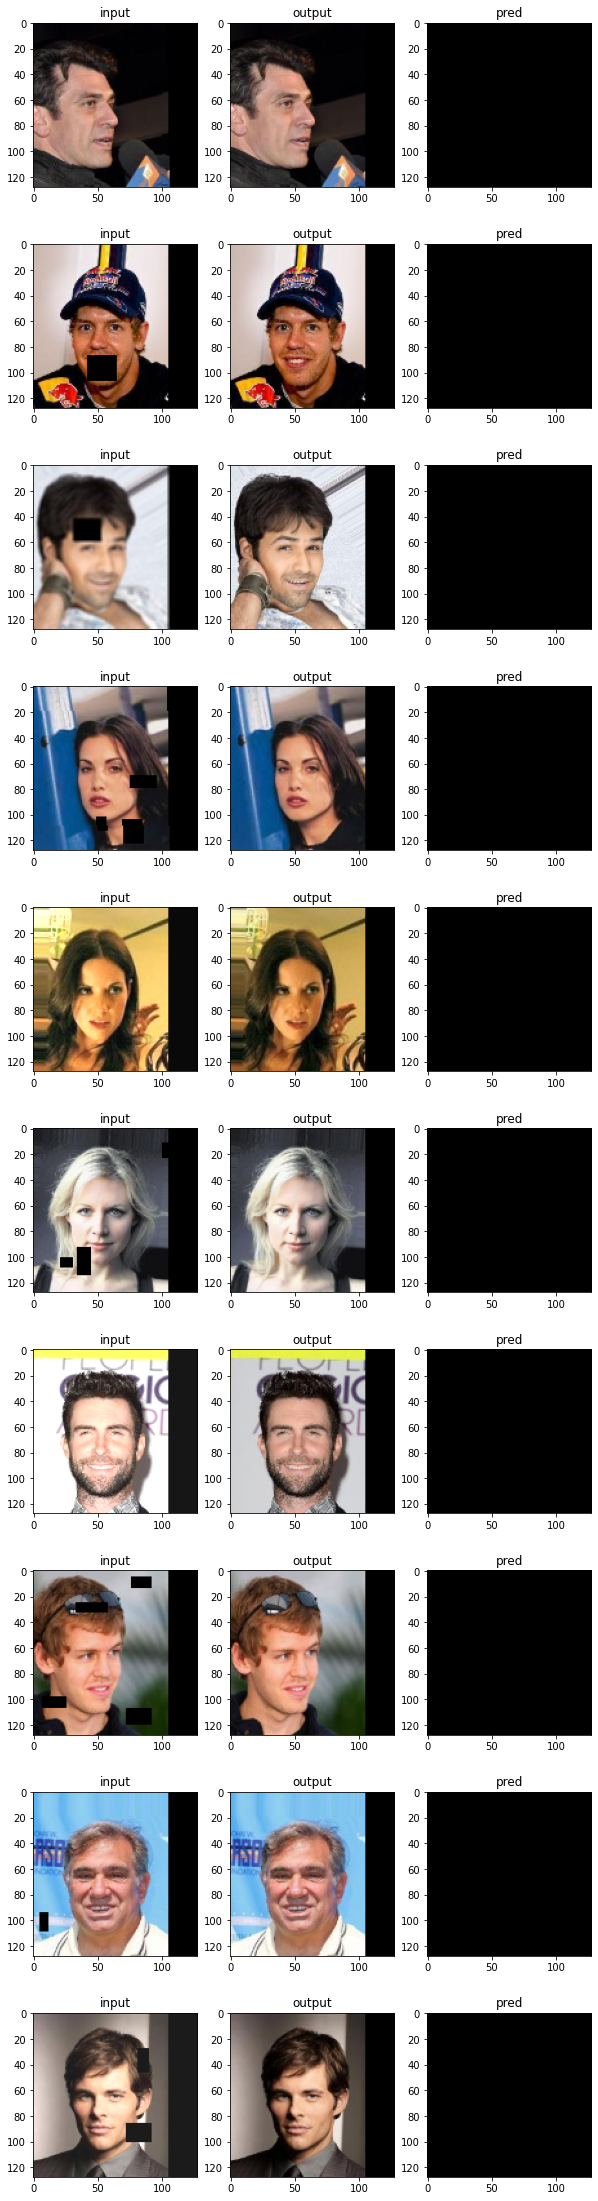

In [5]:
visualize_prediction(
    model=None,
    dataset=datasets['train'],
)

## Define model
![alt text](pics/vae.png "Title")

In [6]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        b, c = x.shape
        return x.view(b, c, 1, 1)

class VariationalAE(nn.Module):
    
    def __init__(
        self,
        downlayers: nn.Module,
        uplayers: nn.Module,
        hidden_dim: int=512,
        latent_dim: int=512,
    ) -> None:
        
        super().__init__()
        
        self.down = downlayers()
        self.up = uplayers()
        
        self.agg_down = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                kernel_size=(image_size[0] // 32, image_size[1] // 32),
                stride=2,
            ),
            Flatten(),
        )
        
        self.agg_up = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            UnFlatten(),
            nn.ConvTranspose2d(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                kernel_size=(image_size[0] // 32, image_size[1] // 32),
                stride=2,
            ),
        )
        
        self.mu_repr = nn.Linear(hidden_dim, latent_dim)
        self.log_sigma_repr = nn.Linear(hidden_dim, latent_dim)
        
        # hack to get sampling on the GPU
        self.samling = torch.distributions.Normal(0, 1)
        self.samling.loc = self.samling.loc.to(device)
        self.samling.scale = self.samling.scale.to(device)
        
        self.init_weights()
        
    def init_weights(
        self,
    ) -> None:
        
        for m in self.modules():
            
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(
                    tensor=m.weight,
                )
                nn.init.zeros_(
                    tensor=m.bias,
                )
        
    def _encode(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:
        
        x = self.down(x)
        x = self.agg_down(x)
        
        return x
    
    def _decode(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:
        
        x = self.agg_up(x)
#         print('after agg up: ', x)
        x = self.up(x)
#         print('after up:', x)
        return x
    
    def _reparametrize(
        self,
        mu: torch.Tensor,
        log_sigma: torch.Tensor,
    ) -> torch.Tensor:
        
        eps = self.samling.sample(mu.shape)
        x = eps * log_sigma.exp() + mu
        
        return x
        
    def forward(
        self,
        x: torch.Tensor,
        embedding: bool=True,
    ) -> torch.Tensor:
        
        latent_repr = self._encode(x)
        
        if embedding:
            return latent_repr
        
        latent_mu = self.mu_repr(latent_repr)
        latent_log_sigma = self.log_sigma_repr(latent_repr)
        
        sample = self._reparametrize(latent_mu, latent_log_sigma)
        
        image = self._decode(sample)
        
        return {
            'pred_image': image,
            'mu': latent_mu,
            'log_sigma': latent_log_sigma,
        }

In [7]:
latent_dim=128
hidden_dim=512

model = VariationalAE(
    downlayers=resnet18,
    uplayers=deconv_resnet18,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
).to(device)

## Define trainer params

In [8]:
lr=8e-4
weights=[1, 1]

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=lr,
    weight_decay=1e-3,
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=lr,
    steps_per_epoch=len(dataloaders['train']),
    epochs=epochs,
)
loss = VAELoss(weights=weights)

save_path=f'metrics/VAE/dataset=celeba_epoch={epochs}_bs={bs}_lr={lr}_loss={loss.__class__.__name__}_weights={weights}_latent={latent_dim}_norm=max_imsize={image_size}'
visualiser = Collector(
    root_graphics=save_path,
    root_desc=save_path,
    phases=list(transformations.keys()),
)

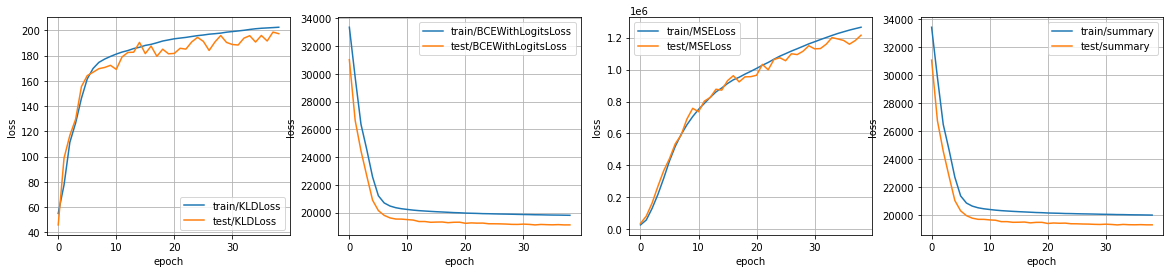

train, lr=0.000180:   0%|                                                                                                           | 0/224 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [9]:
trainer(model, optimizer, scheduler, dataloaders, epochs, device, loss, visualiser, save_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

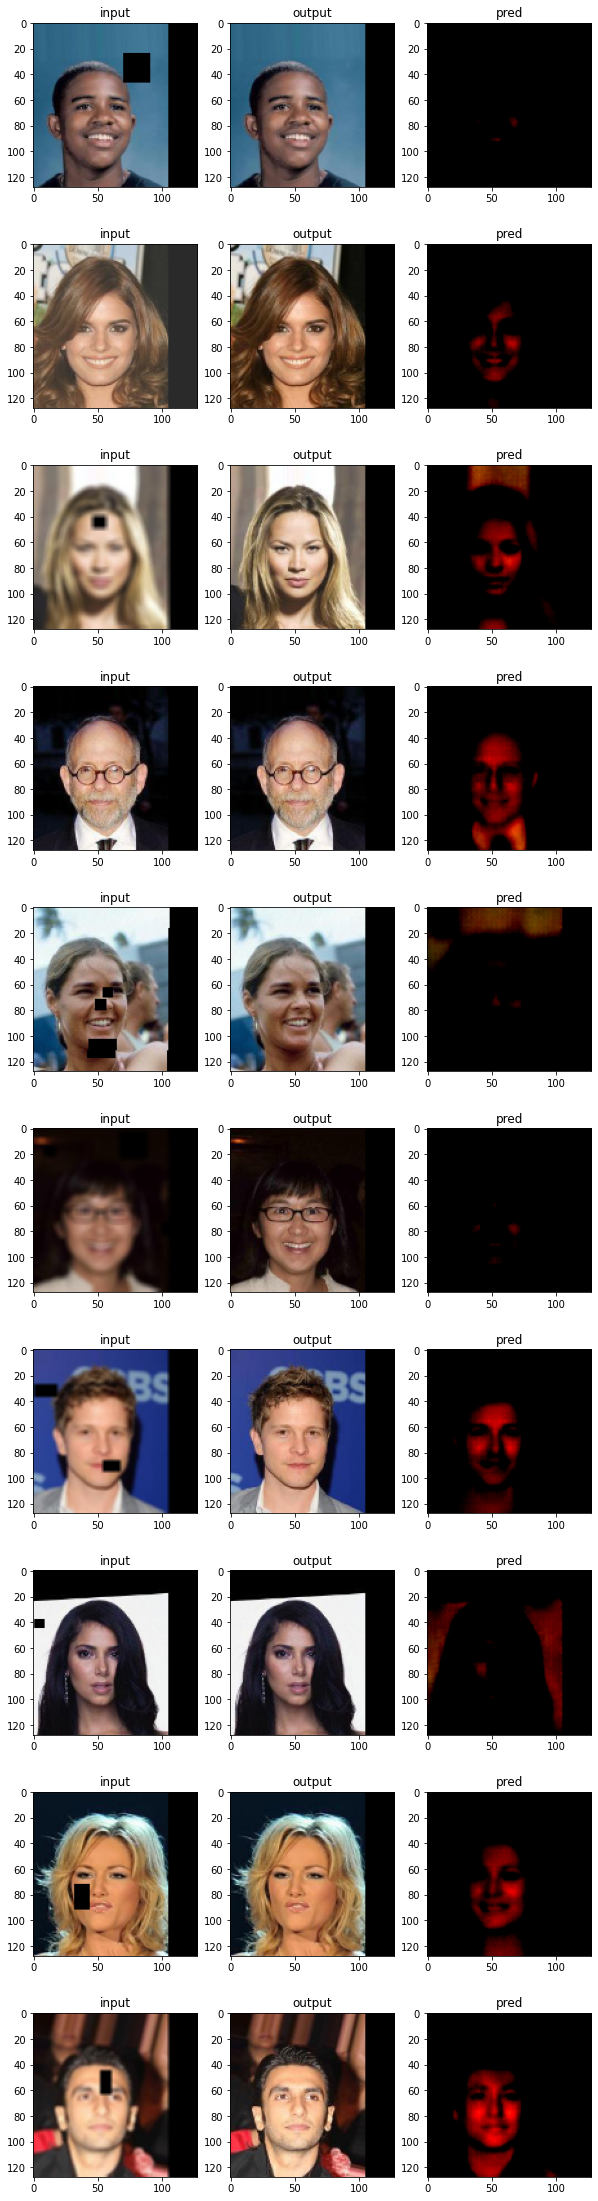

In [349]:
visualize_prediction(
    model=model,
    dataset=datasets['train'],
)

## Visualize predictions
### Let's sample from VAE

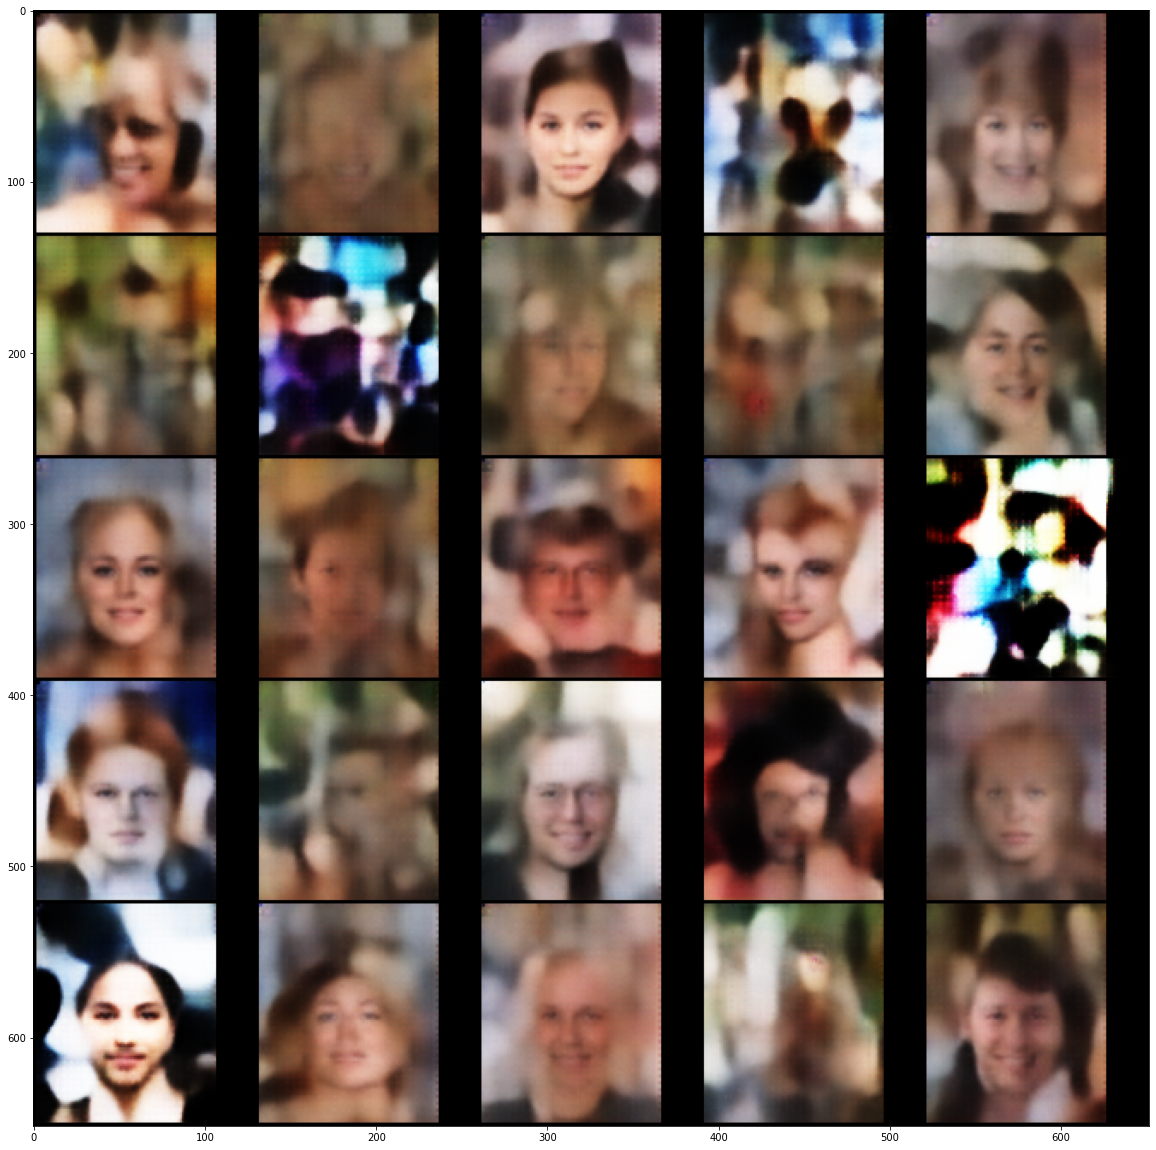

In [10]:
plt.rcParams["figure.figsize"] = (20,40)

hidden_repr = torch.randn(25, hidden_dim).to(device)

latent_mu = model.mu_repr(hidden_repr)
latent_log_sigma = model.log_sigma_repr(hidden_repr)

sample = model._reparametrize(latent_mu, latent_log_sigma)
images = model._decode(sample)

plt.imshow(
    torchvision.utils.make_grid(
        tensor=images.sigmoid().detach().cpu(),
        nrow=5,
    ).permute(1, 2, 0)
)

### Load model

In [8]:
latent_dim=128
hidden_dim=512

device = 'cpu'

model = VariationalAE(
    downlayers=resnet18,
    uplayers=deconv_resnet18,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
).to(device)

In [9]:
model.load_state_dict(
    torch.load(
        f='metrics/VAE/dataset=celeba_epoch=50_bs=812_lr=0.0008_loss=VAELoss_weights=[1, 1]_latent=128_norm=max_imsize=[128, 128]/model.pth',
        map_location=device,
    )
)

<All keys matched successfully>

# Create Hilbert reconstructure

In [11]:
#!g1.1
from scipy.stats import norm
from hilbertcurve.hilbertcurve import HilbertCurve


# from R^H to [0, 1]^H
def s_inv(x):

    return norm.cdf(x.detach().numpy())

# from [0, 1]^H to Hilbert points (stertch x from [0, 1] to [0, 7])
def proj_to_im_f(x : np.array, p):
    
    return (x * (2**p - 1)).astype(int).clip(0, 2**p - 1)

# from Hilbert points (batch of [0, 2^p - 1]^H; e.g. [64, 128]) to Hilbert distances ([batch size])
def f_inv(points : np.array, p):
    h = len(points[0])
    hilbert_curve = HilbertCurve(p, h)
    
    return hilbert_curve.distances_from_points(points)
    
# from Hilbert distances to Hilbert points
def f(distances, p, h):
    hilbert_curve = HilbertCurve(p, h)
    
    return hilbert_curve.points_from_distances(distances)


# from Hilbert points to R^H
# points : batch of [0, 2^p - 1]^H
def s(points, p):
    
    return norm.ppf(np.clip(np.array(points), a_min=1e-10, a_max=None) / 2**p)

In [12]:
#!g1.1
def hilbert_compress(x, p=1):
    out = s_inv(x)
    out = proj_to_im_f(out, p)
    out = f_inv(out, p)
    
    return out

def hilbert_compress_inv(distances, h, p=1):
    out = f(distances, p, h)
    out = s(out, p)
    
    return out

def hyper_vae(images, vae, p):
    
    latent_repr = vae._encode(images.to(device))
    
    latent_mu = vae.mu_repr(latent_repr)
    latent_logsigma = vae.log_sigma_repr(latent_repr)

    hilbert_mu = hilbert_compress(latent_mu, p=p)
    hilbert_logsigma = hilbert_compress(latent_logsigma, p=p)
        
    mu = hilbert_compress_inv(hilbert_mu, latent_dim, p=p)
    logsigma = hilbert_compress_inv(hilbert_logsigma, latent_dim, p=p)

    
    mu = torch.from_numpy(mu)
    logsigma = torch.from_numpy(logsigma)
    
    z = vae._reparametrize(mu, logsigma).to(torch.float32)
    reconstruction = vae._decode(z.to(device))
    
    return reconstruction

In [61]:
index = random.randint(0, len(datasets['train']))
sample = datasets['train'][index]

In [62]:
from ipywidgets import interact


@interact
def func(j=(1, 10)):
    ims = []
    model.train(False)
    with torch.no_grad():
        for i in range(16):
            ims.append(
                hyper_vae(
                datasets['test'][i]['images']['test_image'].unsqueeze(0),
                vae=model,
                p=j,
            ).cpu().sigmoid()[0]
            )

    plt.figure(figsize=(10, 10))
    plt.imshow(make_grid(ims, nrow=4).permute(1, 2, 0))

interactive(children=(IntSlider(value=5, description='j', max=10, min=1), Output()), _dom_classes=('widget-int…

In [59]:
import matplotlib.animation as animation
import matplotlib.axes as axes

def make_gif(
    n_iter: int,
    filename: str,
) -> None:
    
    ps = list(range(1, n_iter + 1))

    fig, ax = plt.subplots(1)

    def animate(i: int):

        ax.clear()

        ims = []
        model.train(False)
        with torch.no_grad():
            for j in range(16):
                ims.append(
                    hyper_vae(
                    datasets['test'][j]['images']['test_image'].unsqueeze(0),
                    vae=model,
                    p=ps[i],
                ).cpu().sigmoid()[0]
            )
        
        ax.set_title(f'p={ps[i]}', fontsize=30)
        plot = ax.imshow(make_grid(ims, nrow=4).permute(1, 2, 0))
        

        return plot


    anim = animation.FuncAnimation(
        fig, 
        animate, 
        frames=n_iter,
        interval=10,
        repeat=False,
    )

    anim.save(
        filename,
        writer='pillow', 
        fps=5,
    )

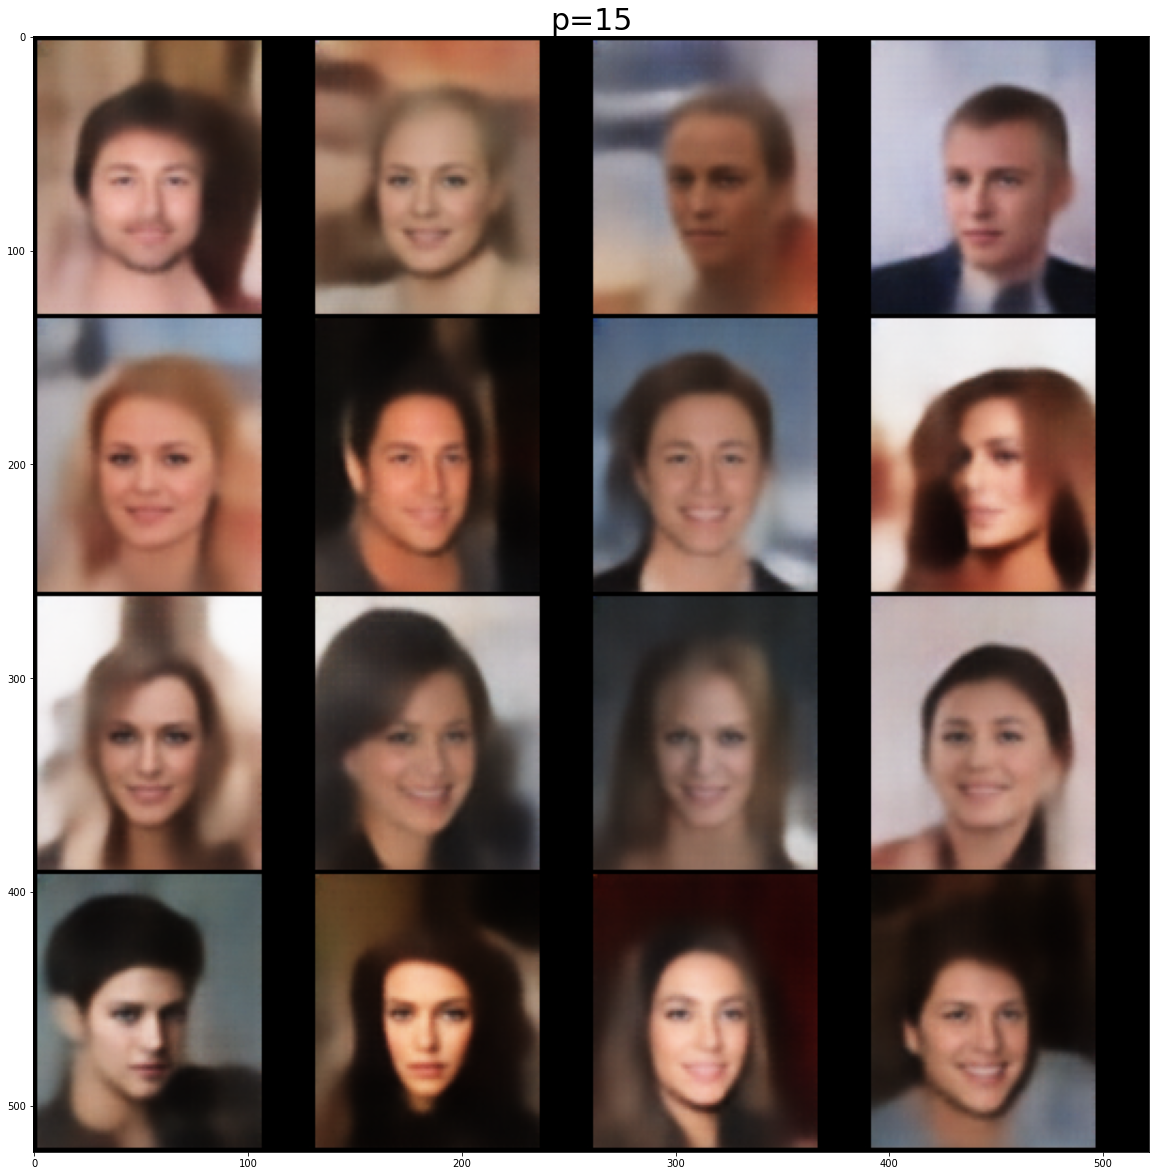

In [60]:
make_gif(15, 'file.gif')

In [65]:
np.random.uniform()

0.9873983751682727